In [1]:
#%pip install /Users/greg/downloads/smote_variants-1.0.1 --force-reinstall

## Import our libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import sklearn
#import imblearn

## Load the dataset we'll be using for this analysis.

In [3]:
data_path = "/Volumes/Scratch/pima/diabetes.csv"
df = pd.read_csv(data_path, header = 0)

## Emit shape, head and statistics to get a sense of what's there.

In [4]:
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.Outcome.value_counts(normalize = True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

## This dataset uses zeroes in features that don't make sense to represent missing data.

In [7]:
nz_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[nz_cols] = df[nz_cols].replace(0, np.nan)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

## We have 768 rows. 374 (49%) are missing an Insulin value and 227 (30%) are missing SkinThickness. Let's see how much predictive power those two are likely to have.

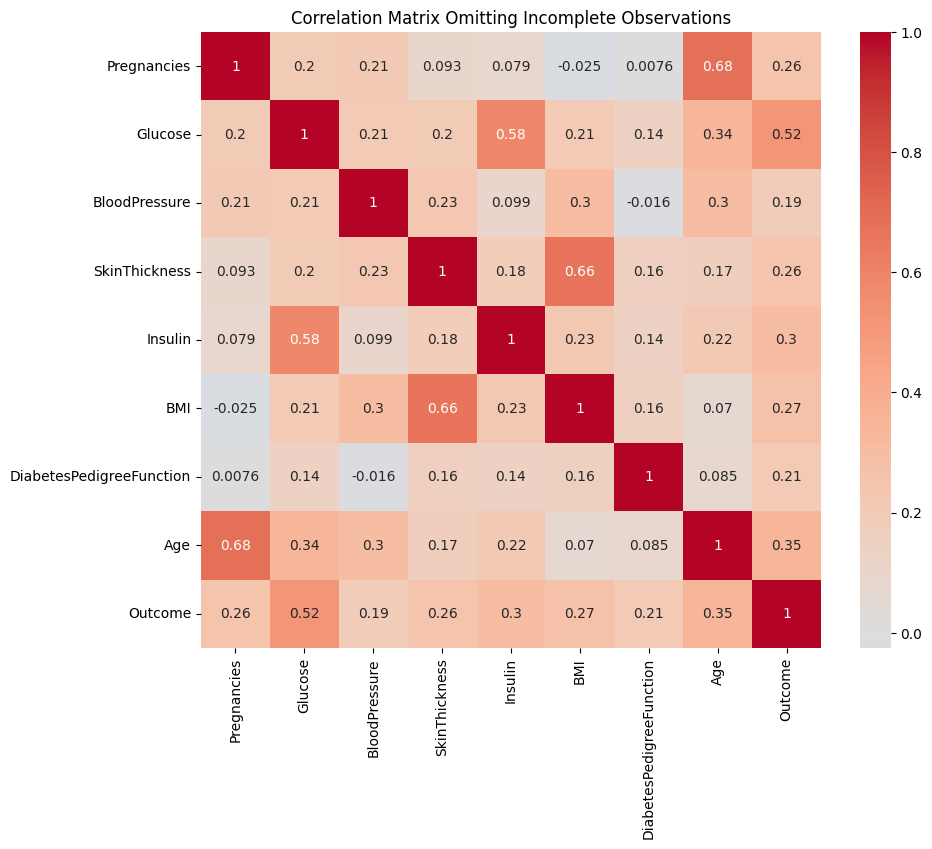

In [8]:
plt.figure(figsize = (10, 8))
corr_map = sns.heatmap(df.dropna().corr(), cmap = 'coolwarm', center = 0, annot = True)
corr_map.set_title('Correlation Matrix Omitting Incomplete Observations')
plt.savefig('pima-corr-full.png', bbox_inches = 'tight')
plt.show()

## As individual predictors SkinThickness and Insulin are both middle-of-the pack. If they were very poor it would be tempting to just ignore those attributes and carry on, but this is a more challenging call. Let's run a very simple test to compare the results.

In [9]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [10]:
df_aggressive = df.dropna()
df_cautious = df.drop(['SkinThickness', 'Insulin'], axis = 1).dropna()
print(f"Aggressively cleaned: {df_aggressive.shape}")
print(f"Cautiously cleaned: {df_cautious.shape}")

Aggressively cleaned: (392, 9)
Cautiously cleaned: (724, 7)


Outcome
0    0.666667
1    0.333333
Name: proportion, dtype: float64
Outcome
0    0.673469
1    0.326531
Name: proportion, dtype: float64
[0.07055586 0.26288293 0.07502282 0.09512992 0.17008939 0.12059132
 0.08685014 0.11887762]
F-score: 0.6927710843373494


<Figure size 1000x800 with 0 Axes>

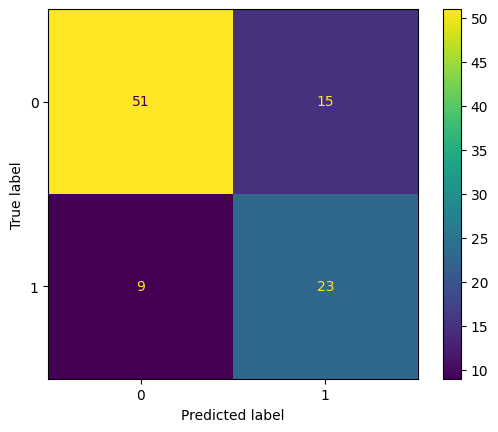

<Figure size 1000x800 with 0 Axes>

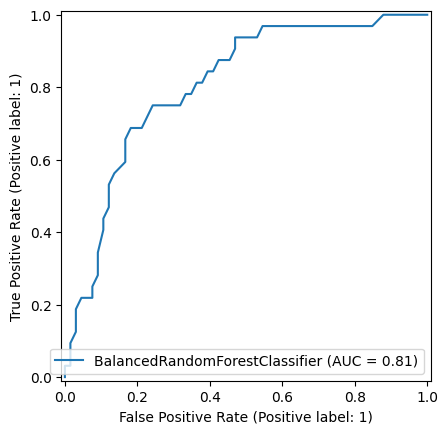

In [11]:
X = df_aggressive.drop('Outcome', axis = 1)
y = df_aggressive['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
model = BalancedRandomForestClassifier()
scaler = MinMaxScaler()

model.fit(scaler.fit_transform(X_train), y_train)
print(model.feature_importances_)
y_test_pred = model.predict(scaler.transform(X_test))

print(f"F-score: {fbeta_score(y_test, y_test_pred, beta = 2)}")

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-aggressive-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-aggressive-roc.png');
plt.show()

Outcome
0    0.642726
1    0.357274
Name: proportion, dtype: float64
Outcome
0    0.696133
1    0.303867
Name: proportion, dtype: float64
[0.08376563 0.29818837 0.09735093 0.21899775 0.13982281 0.16187452]
F-score: 0.7118055555555556


<Figure size 1000x800 with 0 Axes>

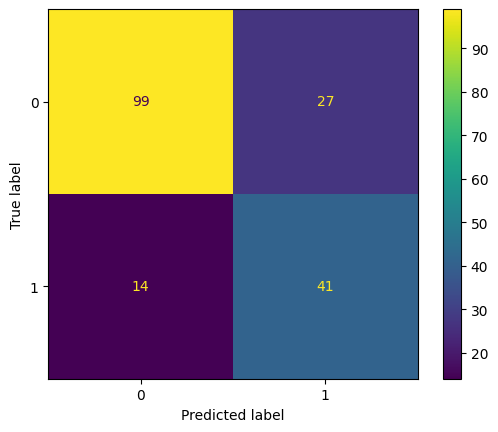

<Figure size 1000x800 with 0 Axes>

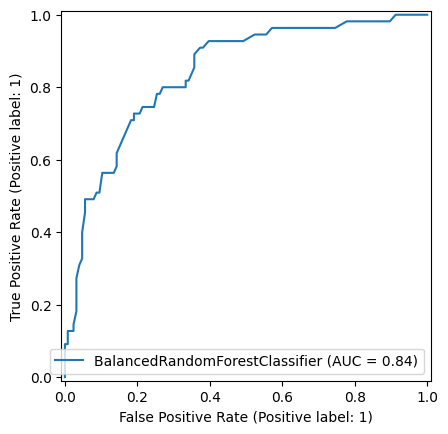

In [12]:
X = df_cautious.drop('Outcome', axis = 1)
y = df_cautious['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
model = BalancedRandomForestClassifier()
scaler = MinMaxScaler()

model.fit(scaler.fit_transform(X_train), y_train)
print(model.feature_importances_)
y_test_pred = model.predict(scaler.transform(X_test))

print(f"F-score: {fbeta_score(y_test, y_test_pred, beta = 2)}")

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-cautious-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-cautious-roc.png');
plt.show()

## So it looks like we did better dropping those two columns. AUC and F-score both improved a fair amount. It's kind of interesting that the model trained on the aggressively cleaned data ended up considering Insulin as the second-most important feature even though it was noticeably behind Age in the single-feature correlation matrix. So we'll use df_cautious from here on out.

In [13]:
# Technically we do not need to do this because this was the last test case, but for clarity we run it again.
X = df_cautious.drop('Outcome', axis = 1)
y = df_cautious['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Outcome
0    0.642726
1    0.357274
Name: proportion, dtype: float64
Outcome
0    0.696133
1    0.303867
Name: proportion, dtype: float64


In [14]:
def anis_ali(X, y, random_state = 0):
    return X, y

In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestCentroid
from kmodes.kmodes import KModes
from minisom import MiniSom
import Cluster_Ensembles as CE
from scipy import stats

def relabel_clusters(labels, reference_labels, label_count):
    cost_matrix = np.zeros((len(np.unique(labels)), len(np.unique(reference_labels))))
    for i, l1 in enumerate(np.unique(labels)):
        for j, l2 in enumerate(np.unique(reference_labels)):
            cost_matrix[i, j] = -np.sum((labels == l1) & (reference_labels == l2))

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {old_label:new_label for old_label, new_label in zip(np.unique(labels)[row_ind], np.unique(reference_labels)[col_ind])}
    mapped_labels = np.array([mapping[label] for label in labels])
    return mapped_labels
    
def onan(X, y, random_state = 0):
    majority_indices = np.where(y == 0)[0] # Assuming false is the majority class.
    minority_indices = np.where(y == 1)[0] # Assuming true is the minority class.
    n = len(majority_indices)
    m = len(minority_indices)
    num_clusters = m
    print(num_clusters)

    majority_predictors = X[majority_indices]

    cluster1 = KMeans(n_clusters = m, init = 'random', random_state = random_state)
    cluster2 = KModes(n_clusters = m, random_state = random_state)
    cluster3 = KMeans(n_clusters = m, random_state = random_state)
    cluster4 = MiniSom(m, 1, X.shape[1])
    cluster4.random_weights_init(X)
    cluster5 = AgglomerativeClustering(n_clusters = m, linkage = 'single')

    cluster1.fit(majority_predictors)
    cluster2.fit(majority_predictors)
    cluster3.fit(majority_predictors)
    cluster4.train_batch(majority_predictors, 5000)
    cluster5.fit(majority_predictors)

    part1 = cluster1.labels_
    part2 = relabel_clusters(cluster2.labels_, part1, num_clusters)
    part3 = relabel_clusters(cluster3.labels_, part1, num_clusters)
    part4 = relabel_clusters(np.array([int(cluster4.winner(x)[0]) for x in majority_predictors]), part1, num_clusters)
    part5 = relabel_clusters(cluster5.labels_, part1, num_clusters)

    all_parts = np.row_stack((part1, part2, part3, part4, part5))
    consensus_parts = stats.mode(all_parts).mode
    augmented = np.column_stack((majority_predictors, consensus_parts))
    maj_frame = pd.DataFrame(augmented)
    maj_means = maj_frame.groupby(maj_frame.columns[-1]).mean()

    # It's likely that in the course of consensus building we may lose some clusters, so pad it from the original data.
    supp_indices = np.random.choice(range(majority_predictors.shape[0]), max(0, m - maj_means.shape[0]), replace = False)

    X_new = np.row_stack((X[minority_indices], maj_means.to_numpy(), majority_predictors[supp_indices]))
    y_new = np.array([1] * m + [0] * maj_means.shape[0] + [0] * supp_indices.shape[0])
    
    return X_new, y_new

In [16]:
def lee_seo(X, y, random_state = 0):
    return X, y

In [17]:
from imblearn import FunctionSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from smote_variants import SUNDO
from sklearn.utils import Bunch

In [18]:
# Standard resampling methods, and we will also be using X_train and y_train directly.
X_train_under, y_train_under = RandomUnderSampler(random_state = 42).fit_resample(X_train, y_train)
X_train_over, y_train_over = RandomOverSampler(random_state = 42).fit_resample(X_train, y_train)
X_train_smote, y_train_smote = SMOTE(random_state = 42).fit_resample(X_train, y_train)

# SUNDO - Cateni, Colla, and Vannucci (2014)
feature_names = X_train.columns.tolist()
target_column = 'Outcome'
sundo_dataset = Bunch(data = X_train.to_numpy(), target = y_train.to_numpy(),
                      feature_names = feature_names, target_names = [target_column])
X_train_sundo, y_train_sundo = SUNDO(random_state = 42).fit_resample(sundo_dataset['data'], sundo_dataset['target'])

# Mahalanobis - Anis and Ali (2017)
X_train_mahal, y_train_mahal = FunctionSampler(func = anis_ali, kw_args={'random_state': 42}).fit_resample(X_train, y_train)

# Consensus Clustering - Onan (2019)
X_train_clust, y_train_clust = FunctionSampler(func = onan, kw_args={'random_state': 42}).fit_resample(X_train, y_train)

# Active Learning - Lee and Seo (2022)
X_train_active, y_train_active = FunctionSampler(func = lee_seo, kw_args={'random_state': 42}).fit_resample(X_train, y_train)

2025-04-20 15:23:52,415:INFO:SUNDO: Running sampling via ('SUNDO', "{'nn_params': {}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SUNDO'}")
2025-04-20 15:23:52,416:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-04-20 15:23:52,416:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


194


In [19]:
print(f"Base Training Set: {X_train.shape}")
print(f"Random Oversampling Training Set: {X_train_over.shape}")
print(f"Random Undersampling Training Set: {X_train_under.shape}")
print(f"SMOTE Training Set: {X_train_smote.shape}")
print(f"SUNDO Training Set: {X_train_sundo.shape}")
#print(f"Similarity Undersampling Training Set: {X_train_mahal.shape}")
print(f"Cluster Undersampling Training Set: {X_train_clust.shape}")
#print(f"Learned Undersampling Training Set: {X_train_active.shape}")

Base Training Set: (543, 6)
Random Oversampling Training Set: (698, 6)
Random Undersampling Training Set: (388, 6)
SMOTE Training Set: (698, 6)
SUNDO Training Set: (519, 6)
Cluster Undersampling Training Set: (388, 6)


Feature Weights: [0.08707958 0.30415701 0.1020499  0.19699185 0.15517569 0.15454597]


<Figure size 1000x800 with 0 Axes>

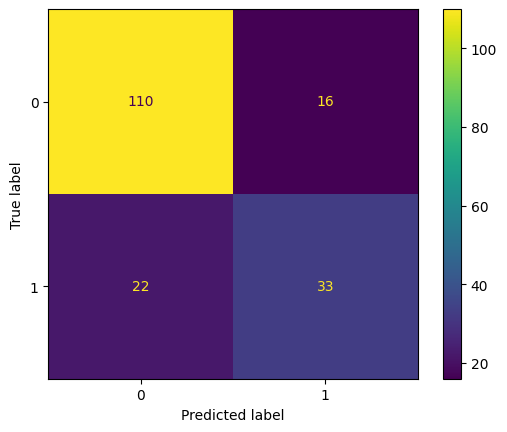

<Figure size 1000x800 with 0 Axes>

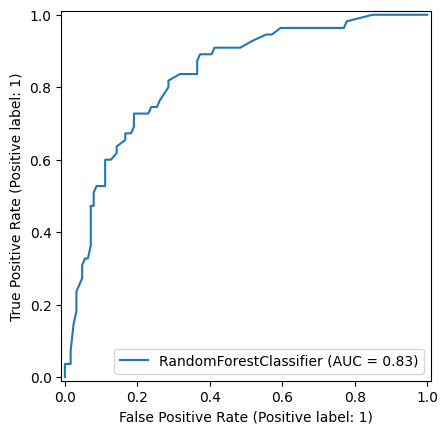

In [20]:
# Let's just try them all with random forest.

model_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Cluster'],
                             columns=['F2-Score', 'AUC'])
feature_weights = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Cluster'],
                              columns=X_train.columns)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

model = RandomForestClassifier()
scaler = MinMaxScaler()

model.fit(scaler.fit_transform(X_train), y_train)
print(f"Feature Weights: {model.feature_importances_}")
y_test_pred = model.predict(scaler.transform(X_test))

model_metrics.at['Base', 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
model_metrics.at['Base', 'AUC'] = roc_auc_score(y_test, y_test_pred)
feature_weights.loc['Base'] = model.feature_importances_

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-base-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-base-roc.png');
plt.show()

Feature Weights: [0.08890795 0.29791764 0.09482516 0.2162618  0.15654678 0.14554068]


<Figure size 1000x800 with 0 Axes>

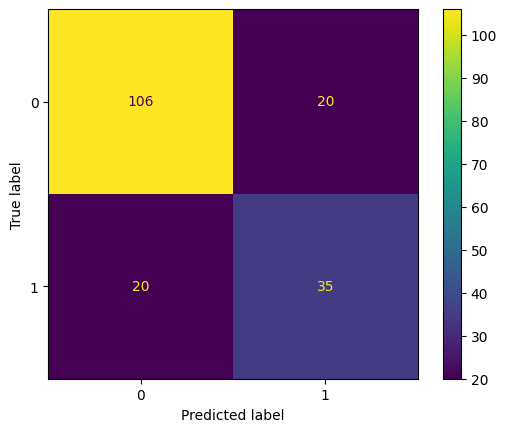

<Figure size 1000x800 with 0 Axes>

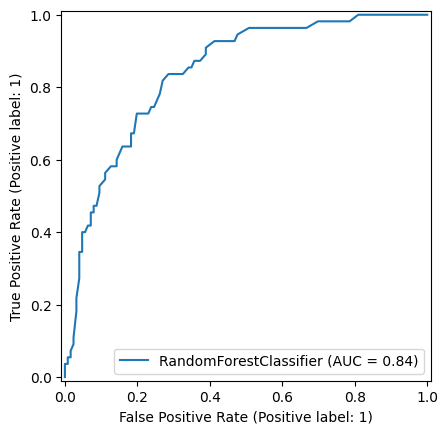

In [21]:
# Let's just try them all with random forest.

model.fit(scaler.fit_transform(X_train_over), y_train_over)
print(f"Feature Weights: {model.feature_importances_}")
y_test_pred = model.predict(scaler.transform(X_test))

model_metrics.at['RandOver', 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
model_metrics.at['RandOver', 'AUC'] = roc_auc_score(y_test, y_test_pred)
feature_weights.loc['RandOver'] = model.feature_importances_

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-rover-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-rover-roc.png');
plt.show()

Feature Weights: [0.09144602 0.27024457 0.0961276  0.2365602  0.15362747 0.15199413]


<Figure size 1000x800 with 0 Axes>

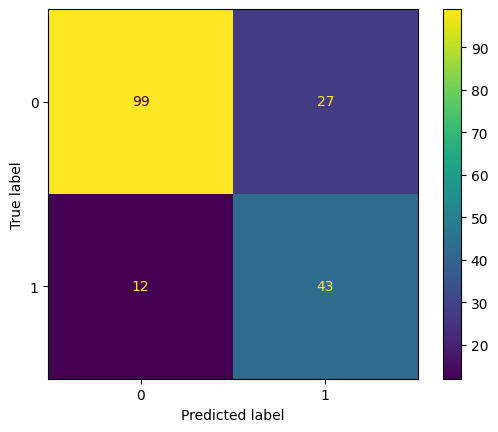

<Figure size 1000x800 with 0 Axes>

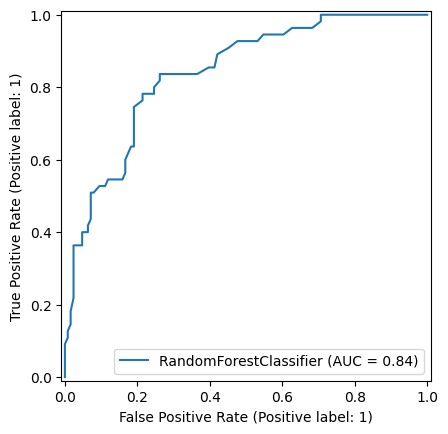

In [22]:
# Let's just try them all with random forest.

model.fit(scaler.fit_transform(X_train_under), y_train_under)
print(f"Feature Weights: {model.feature_importances_}")
y_test_pred = model.predict(scaler.transform(X_test))

model_metrics.at['RandUnder', 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
model_metrics.at['RandUnder', 'AUC'] = roc_auc_score(y_test, y_test_pred)
feature_weights.loc['RandUnder'] = model.feature_importances_

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-runder-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-runder-roc.png');
plt.show()

Feature Weights: [0.0759668  0.29611329 0.10536183 0.20943138 0.15180571 0.161321  ]


<Figure size 1000x800 with 0 Axes>

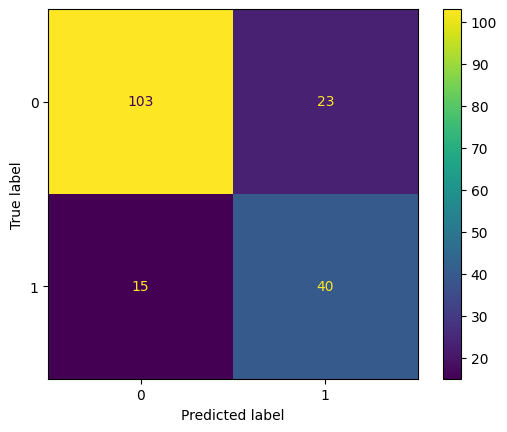

<Figure size 1000x800 with 0 Axes>

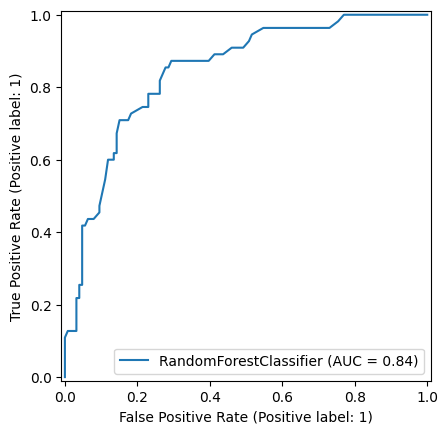

In [23]:
# Let's just try them all with random forest.

model.fit(scaler.fit_transform(X_train_smote), y_train_smote)
print(f"Feature Weights: {model.feature_importances_}")
y_test_pred = model.predict(scaler.transform(X_test))

model_metrics.at['SMOTE', 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
model_metrics.at['SMOTE', 'AUC'] = roc_auc_score(y_test, y_test_pred)
feature_weights.loc['SMOTE'] = model.feature_importances_

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-smote-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-smote-roc.png');
plt.show()

Feature Weights: [0.12676757 0.27220622 0.103179   0.18762047 0.15680267 0.15342407]


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

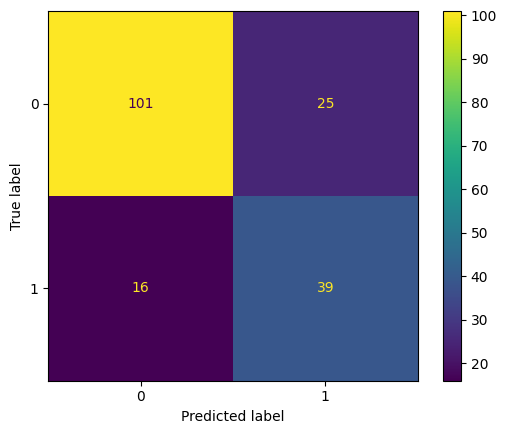

/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

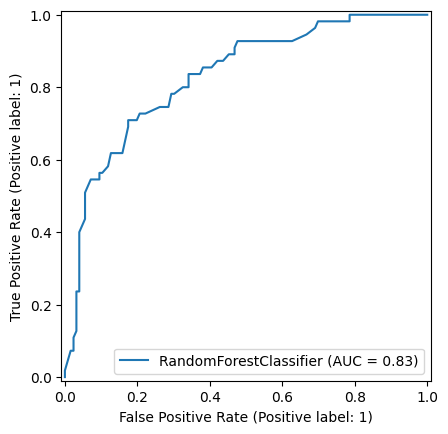

In [24]:
# Let's just try them all with random forest.

model.fit(scaler.fit_transform(X_train_sundo), y_train_sundo)
print(f"Feature Weights: {model.feature_importances_}")
y_test_pred = model.predict(scaler.transform(X_test))

model_metrics.at['SUNDO', 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
model_metrics.at['SUNDO', 'AUC'] = roc_auc_score(y_test, y_test_pred)
feature_weights.loc['SUNDO'] = model.feature_importances_

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-sundo-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-sundo-roc.png');
plt.show()

Feature Weights: [0.08282773 0.27603644 0.10478072 0.21657444 0.16886824 0.15091243]


<Figure size 1000x800 with 0 Axes>

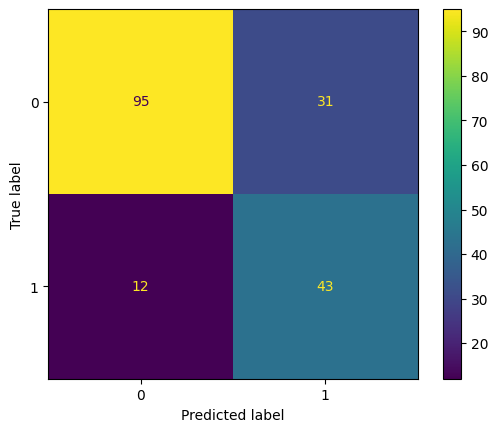

<Figure size 1000x800 with 0 Axes>

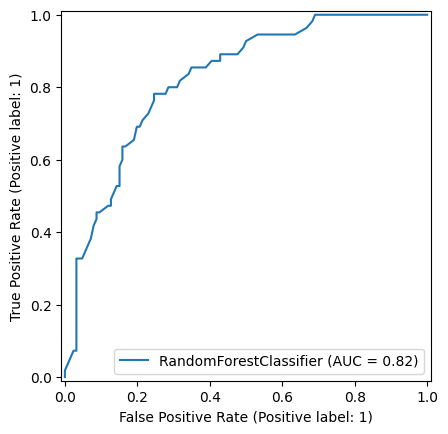

In [25]:
# Let's just try them all with random forest.

model.fit(scaler.fit_transform(X_train_clust), y_train_clust)
print(f"Feature Weights: {model.feature_importances_}")
y_test_pred = model.predict(scaler.transform(X_test))

model_metrics.at['Cluster', 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
model_metrics.at['Cluster', 'AUC'] = roc_auc_score(y_test, y_test_pred)
feature_weights.loc['Cluster'] = model.feature_importances_

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('pima-cluster-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('pima-cluster-roc.png');
plt.show()

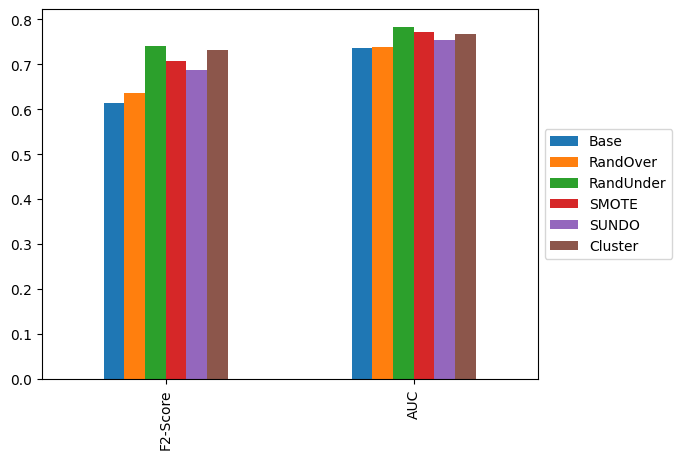

In [26]:
model_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('pima-metrics.png', bbox_inches = 'tight')
plt.show()

In [27]:
model_metrics

,F2-Score,AUC
Base,0.613383,0.736508
RandOver,0.636364,0.738817
RandUnder,0.741379,0.783766
SMOTE,0.706714,0.772367
SUNDO,0.68662,0.755339
Cluster,0.731293,0.767893


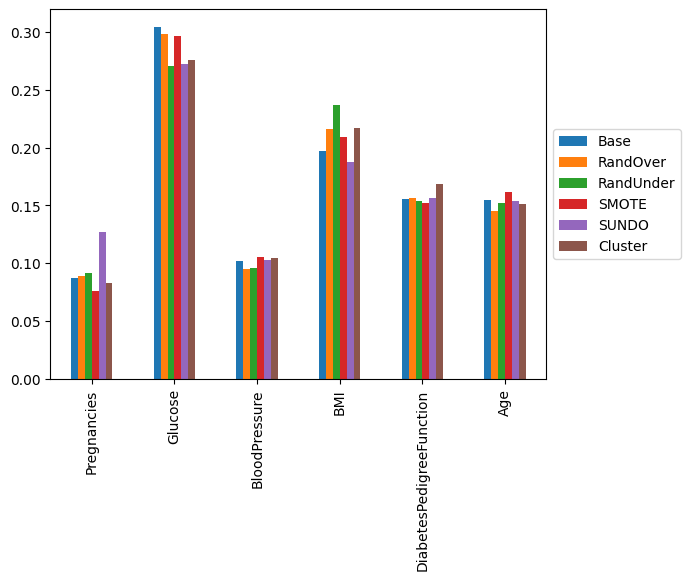

In [28]:
feature_weights.T.plot(kind='bar')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('pima-features.png', bbox_inches = 'tight')
plt.show()

In [29]:
feature_weights

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
Base,0.08708,0.304157,0.10205,0.196992,0.155176,0.154546
RandOver,0.088908,0.297918,0.094825,0.216262,0.156547,0.145541
RandUnder,0.091446,0.270245,0.096128,0.23656,0.153627,0.151994
SMOTE,0.075967,0.296113,0.105362,0.209431,0.151806,0.161321
SUNDO,0.126768,0.272206,0.103179,0.18762,0.156803,0.153424
Cluster,0.082828,0.276036,0.104781,0.216574,0.168868,0.150912


1. Load the dataset.
2. Emit shape, head and statistics to get a sense of what's there.
3. If the dataset uses explicit values to indicate missing data, translate those to NaN.
4. Create base train/test split.
5. Perform initial feature prep, such as recasting as categorical, disaggregating, ....
6. Consider the actual missing values. What proportion of values are missing per feature? If only a handful, maybe drop those records. But if there are features that are missing from a large proportion of observations they're candidates for dropping. Need to consider how predictive the value is when present.
7. Prune any observations that seem immediately problematic.
8. Check class imbalance.
9. Derive alternative training sets from the base using random minority oversampling, random majority undersampling, SMOTE, SUNDO, Onan's, Lee/Seo's, and Anis/Ali. This gives us 8 training sets.
10. Train (at least) kNN, Random Forest, Logistic Regressor, ANN, and one-class SVM per training set.
11. Check training performance via confusion matrix, F-Score, ROC, ....
12. Run the test set through the various models after performing appropriate transformation based on what was done to the training set(s).
13. Check test performance as was done with training.

A key part of our task here is to properly implement the novel samplers. We'll presumably want to look at the stats for the resampled training sets and in the case of the novel samplers attempt to confirm comparable behavior/performance to the authors' claims.

https://imbalanced-learn.org/stable/references/generated/imblearn.FunctionSampler.html for custom sampler injection.
https://pypi.org/project/smote-variants/ for a SUNDO implementation.
Consensus clustering uses k-means, k-modes, k-means++, self-organizing maps, and DIANA algorithm.
Lee and Seo provide pseudo-code.
Anis and Ali use a well-understood distance metric to eliminate majority samples close to minorities and to already-accepted majority samples until the desired number of samples have been dropped.